In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# Taken from https://jwalton.info/Embed-Publication-Matplotlib-Latex/
tex_width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)

In [3]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [4]:
import wandb
api = wandb.Api()

In [5]:
inv_pendulum = {
    "reg-vaml": "3o3s1pmm 3k5d1u2t 2tnqnscb 2mpdhk38".split(),
    "mle": "ub5tkksk an86ovp2 3onbyncd 1f13i5jk".split()
}
# pusher = {
#     "reg-vaml": "3auuc11q 2oorxqww 2mw1ykg9 28r8vddr".split(),
#     "mle": "p0etpoe1 3q8y3c4u 3a04h2ay 112sa3gg".split(),
# }
pusher = {
    "reg-vaml": "24d81p4d 39murfym aqv24uvu 1s67yb1u".split(),
    "mle": "2i0wvziz 9tb2w332 2i9djvn7 2nm9lnlg 250a2vsc 263d1gni 3601br0w rbnb74y5".split()[2:-2],
}

In [6]:
def concat_and_label(run_ids: list, label: str) -> pd.DataFrame:
    histories = []
    for run_id in run_ids:
        run = api.run(f"angelovtt/vaml/{run_id}")
        history = run.history(x_axis="timesteps_total", samples=None)
        assert isinstance(history, pd.DataFrame)
        histories += [history]
        
    dataframe = pd.concat(histories).sort_values("timesteps_total")
    dataframe["label"] = label
    return dataframe

In [7]:
pendulum_history = pd.concat(
    [concat_and_label(run_ids=inv_pendulum[k], label=k) for k in inv_pendulum]
)
pusher_history = pd.concat(
    [concat_and_label(run_ids=pusher[k], label=k) for k in pusher]
)

In [8]:
def rename_fields_old(data: pd.DataFrame):
    data["timesteps"] = data["timesteps_total"]
    data["Average Return"] = data["evaluation/episode_reward_mean"]
    data["Value-Aware Error"] = data["learner/test/vae"]
    data["Negative Log-Likelihood"] = data["learner/test/nll"]
    
def rename_fields_new(data: pd.DataFrame):
    data["timesteps"] = data["timesteps_total"]
    data["Average Return"] = data["evaluation/episode_reward_mean"]
    data["Value-Aware Error"] = data["info/learner/default_policy/vae"]
    data["Negative Log-Likelihood"] = data["info/learner/default_policy/nll"]

In [9]:
def custom_lineplot(ax, data: pd.DataFrame, y: str, legend_loc: str):
    sns.lineplot(
        ax=ax,
        data=data[data[y].notna()], 
        x="timesteps", 
        y=y, 
        hue="label", 
        ci="sd"
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:], labels=labels[:], loc=legend_loc)    
    ax.set_ylabel(None)
    ax.set_title(y)
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0, 0))

In [10]:
def average_returns(ax, data: pd.DataFrame, legend_loc: str = "upper left"):
    custom_lineplot(ax=ax, data=data, y="Average Return", legend_loc=legend_loc)

In [11]:
def vae(ax, data: pd.DataFrame, legend_loc: str = "upper left"):
    custom_lineplot(ax=ax, data=data, y="Value-Aware Error", legend_loc=legend_loc)

In [12]:
def nll(ax, data: pd.DataFrame, legend_loc: str = "upper left"):
    custom_lineplot(ax=ax, data=data, y="Negative Log-Likelihood", legend_loc=legend_loc)

In [13]:
rename_fields_old(pendulum_history)
rename_fields_new(pusher_history)

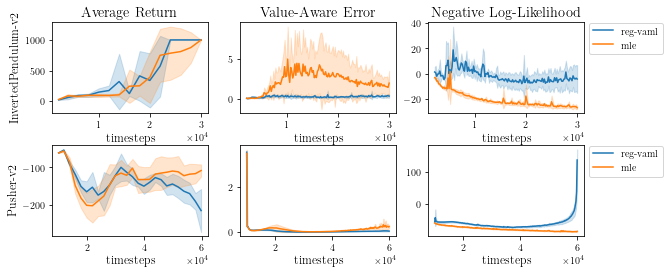

In [14]:
_, axes_mat = plt.subplots(nrows=2, ncols=3, figsize=set_size(tex_width * 2, subplots=(2, 3)))

axes = axes_mat[0]
history = pendulum_history
average_returns(ax=axes[0], data=history)
axes[0].get_legend().remove()
axes[0].set_ylabel("InvertedPendulum-v2")
vae(ax=axes[1], data=history)
axes[1].get_legend().remove()
nll(ax=axes[2], data=history)
axes[2].get_legend().set_bbox_to_anchor((1.0, 1.05))

axes = axes_mat[1]
history = pusher_history
average_returns(ax=axes[0], data=history)
axes[0].get_legend().remove()
axes[0].set_ylabel("Pusher-v2")
vae(ax=axes[1], data=history)
axes[1].get_legend().remove()
nll(ax=axes[2], data=history)
axes[2].get_legend().set_bbox_to_anchor((1.0, 1.05))
for ax in axes:
    ax.set_title(None)

plt.subplots_adjust(hspace=.35)
plt.savefig("output.pdf", bbox_inches="tight")